   # Validation of static linear solver
   
Studies consider a flat/cambered aerofoil models. 
   
The linearisation of the model is performed as follows:
   - A geometrically-exact static solution is obtained for an arbitrary geometry/flow condition;
   - A linearisation is performed about this configuration;
   - incremental displacements/velocities are enforced on the linear models;
All linear solutions are compared to geometrically-exact one.
   

   This version of the linear solver is based on a linearisation of both state and output equations. 
   Being $\Gamma_0$ the circulation at the reference (linearisation) point, and $\Delta\Gamma$ the incremental circulation, the total circulation is computed as:
$$\Gamma=\Gamma_0+\Delta\Gamma$$
Similarly, the total aerodynamic force is obtained as:
$$
F = F_0 + \Delta F
$$

In summary, the discrete-time state-space formulation used is:
$$
\Delta x^{n+1}=A \Delta x^n + B \Delta u^{n+1} \\
\Delta y^{n+1} = C \Delta x^{n+1} + D \Delta u^{n+1}
$$
where $x$ and $u$ are system state and input and the static solution is obtained enforcing:
$$\Delta x^{n+1}=\Delta x^n$$

In [1]:
import os,sys
sys.path.append('..')
import copy

import numpy  as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import uvlm2d_sta as uvlm
import lin_uvlm2d_sta as linuvlm

import geo
import pp_uvlm2d as pp

## Flat plate: exact vs. linearisation

In this test a model of a flat plate at zero angle of attack (results do not change as $\alpha_0$ is varied) is created and linearised. A rotation is imposed on the linear model and the force coefficients are computed. The results are compared against the nonlinear solution for different paneling/angles of attack.

   #### Note: 
   In order to rotate the aerofoil, a set of nodal displacements $\Delta\zeta$ is applied. Importantly, the rotation is exact, i.e. both horizontal and vertical displacements are considered.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Testing steady aerofoil for M=1...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=8...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=16...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg


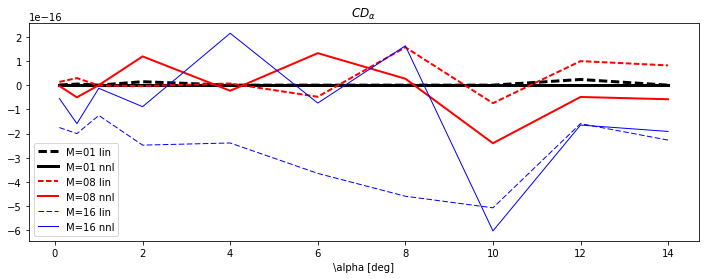

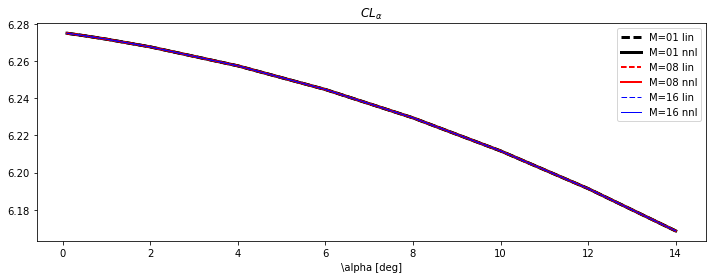

In [2]:
MList=[1,8,16]
DAlphaList=[0.1,0.5,1.,2.,4.,6.,8.,10.,12.,14.] # degs

Nm=len(MList)
Na=len(DAlphaList)

CDlin,CLlin=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

for mm in range(len(MList)):

    # input: reference condition: flat plate at zero angle
    Mw=2
    M=MList[mm]
    alpha=5.*np.pi/180.
    chord=3.
    b=0.5*chord
    Uinf=np.array([20.,0.])
    rho=1.225
    S0=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    S0.build_flat_plate()
    S0.solve_static_Gamma2d()
    Ftot0=np.sum(S0.Faero,0)

    print('Testing steady aerofoil for M=%d...' %M)

    for aa in range(len(DAlphaList)):

        # Perturbation
        dalpha=np.pi/180.*DAlphaList[aa] # angle [rad]
        dUinf=0.0 # velocity [m/s]
        qinf_tot=0.5*rho*(S0.Uabs+dUinf)**2
        print('\talpha==%.2f deg' %DAlphaList[aa])

        ### Linearised solution 
        # Perturb reference state
        ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
        dZeta=ZetaRot-S0.Zeta
        Slin=linuvlm.solver(S0)
        Slin.Zeta=dZeta
        # solve
        Slin.solve_static_Gamma2d()
        # store data
        CDlin[aa,mm],CLlin[aa,mm]=(Ftot0+np.sum(Slin.Faero,0))/\
                                 (qinf_tot*Slin.S0.chord*(alpha+dalpha))

        ### Reference nonlinear solution
        Sref=uvlm.solver(M,Mw,b,Uinf,alpha+dalpha,rho)
        Sref.build_flat_plate()
        # solve
        Sref.solve_static_Gamma2d()
        # store
        CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.Faero,0)/\
                                    (qinf_tot*Sref.chord*(alpha+dalpha))

clist=['k','r','b','0.6',]
fig1 = plt.figure('Drag coefficient',(12,4))
ax1=fig1.add_subplot(111)
fig2 = plt.figure('Lift coefficient',(12,4))
ax2=fig2.add_subplot(111)

for mm in range(Nm):
    #
    ax1.plot(DAlphaList,CDlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax1.plot(DAlphaList,CDnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])
    #
    ax2.plot(DAlphaList,CLlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax2.plot(DAlphaList,CLnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'$CD_\alpha$')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'$CL_\alpha$')
ax2.legend()
plt.show()

The difference in $CL_\alpha$ prediction between the linearised and geometrically-exact  model is shown below:

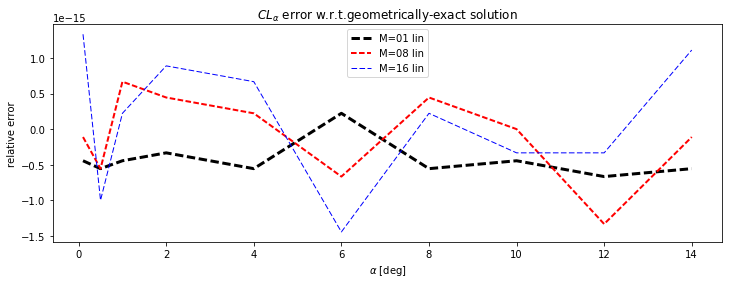

In [3]:
fig1 = plt.figure('Relative error lift coefficient',(12,4))
ax1=fig1.add_subplot(111)
for mm in range(Nm):
    ax1.plot(DAlphaList,CLlin[:,mm]/CLnnl[:,mm]-1.,clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'$CL_\alpha$ error w.r.t.geometrically-exact solution')
ax1.legend()
ax2.legend()
plt.show()

- The nonlinear solution is consistent across parametrisation, with the $CL_\alpha \to 2\pi$ as $\alpha \to 0$; as $\alpha$ increases, the $CL_\alpha$ drops, as a consequence of the exact rotation. The drag is always null, as expected.
- The linearised solution is always consistent with the geometrically-exact one, also predicting the $CL_\alpha$ drop with the angle of attack.

## Cambered plate: exact vs. linearised

In this test a model of a camber plate is considered. Two linearisations of this model, about 0 deg and 10 deg are considered. The total aerodynamic force computed through these two models, $F=F_0 + \Delta F$, is compared to the one predicted by the geometrically-exact solution over a range of angles of attack.

As before, rotation is imposed on the linear model enforcing both $x$ and $y$ displacements.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Testing steady aerofoil for M=20...
	alpha==0.00 deg
	alpha==0.10 deg
	alpha==0.20 deg
	alpha==0.30 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==9.50 deg
	alpha==9.70 deg
	alpha==9.80 deg
	alpha==9.90 deg
	alpha==10.00 deg
	alpha==10.10 deg
	alpha==10.20 deg
	alpha==10.30 deg
	alpha==10.50 deg
	alpha==12.00 deg
	alpha==14.00 deg
	alpha==16.00 deg
	alpha==18.00 deg


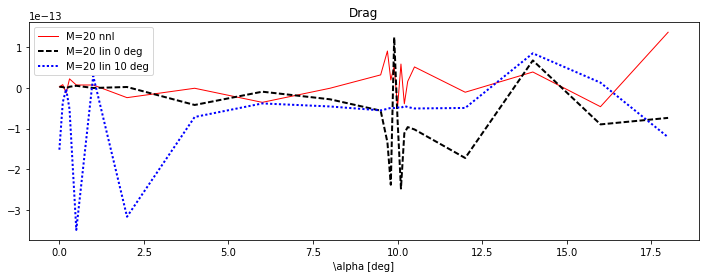

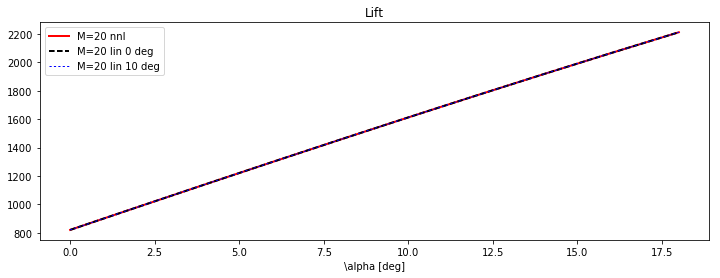

In [4]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CDlin01,CLlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDlin02,CLlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# input:
Mw=2
M=20
chord=3.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

# reference condition 1: aerofoil at 0 deg angle
alpha01=0.*np.pi/180.
S01=uvlm.solver(M,Mw,b,Uinf,alpha01,rho=1.225)
S01.build_camber_plate(Mcamb=10,Pcamb=4)
S01.solve_static_Gamma2d()
Fref01=np.sum(S01.Faero,0)

# reference condition 2: aerofoil at 10 deg angle
alpha02=10.*np.pi/180.
S02=uvlm.solver(M,Mw,b,Uinf,alpha02,rho=1.225)
S02.build_camber_plate(Mcamb=10,Pcamb=4)
S02.solve_static_Gamma2d()
Fref02=np.sum(S02.Faero,0)


print('Testing steady aerofoil for M=%d...' %M)
for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_tot=np.pi/180.*DAlphaList[aa]
    dUinf=0.0 # velocity [m/s]
    qinf_tot=0.5*rho*(S01.Uabs+dUinf)**2
    print('\talpha==%.2f deg' %DAlphaList[aa])

    ### Linearised solution 01:
    # Perturb reference state
    dalpha01=alpha_tot-alpha01 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S01.Zeta,dalpha01)
    dZeta=ZetaRot-S01.Zeta
    Slin01=linuvlm.solver(S01)
    Slin01.Zeta=dZeta
    # solve
    Slin01.solve_static_Gamma2d()
    # store data
    dFtot01=np.sum(Slin01.Faero,0)
    Dlin01[aa,mm],Llin01[aa,mm]=dFtot01+Fref01

    
    ### Linearised solution 02:
    # Perturb reference state
    dalpha02=alpha_tot-alpha02 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S02.Zeta,dalpha02)
    dZeta=ZetaRot-S02.Zeta
    Slin02=linuvlm.solver(S02)
    Slin02.Zeta=dZeta
    # solve
    Slin02.solve_static_Gamma2d()
    # store data
    dFtot02=np.sum(Slin02.Faero,0)
    Dlin02[aa,mm],Llin02[aa,mm]=dFtot02+Fref02


    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf,alpha_tot,rho)
    Sref.build_camber_plate(Mcamb=10,Pcamb=4)
    # solve
    Sref.solve_static_Gamma2d()
    # store
    Dnnl[aa,mm],Lnnl[aa,mm]=np.sum(Sref.Faero,0)


clist=['k','r','b','0.6',]

### Aerodynamic forces
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

#
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])


ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'Drag')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'Lift')
ax2.legend()
plt.show()

As expected, the drag and lift predicted match perfectly across models. A plot of the relative error in computing the $CL_\alpha$ is shown below:

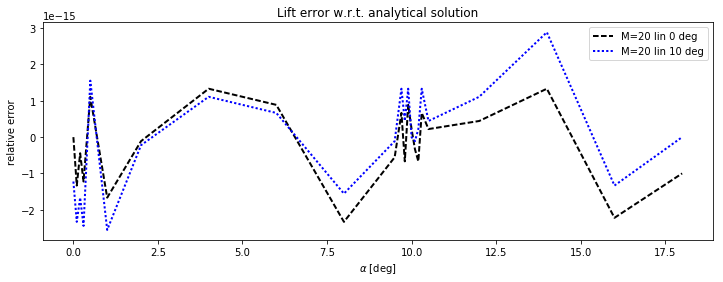

In [5]:
fig1 = plt.figure('Relative error lift',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(DAlphaList,Llin01[:,mm]/Lnnl[:,mm]-1.,'k',lw=2,ls='--',
                                      label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Llin02[:,mm]/Lnnl[:,mm]-1.,'b',lw=2,ls=':',
                                     label=r'M=%.2d lin 10 deg'%MList[mm])
ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'Lift error w.r.t. analytical solution')
ax1.legend()
ax2.legend()
plt.show()

A plot of the aerofoil at 0 and 10 deg is shown below:

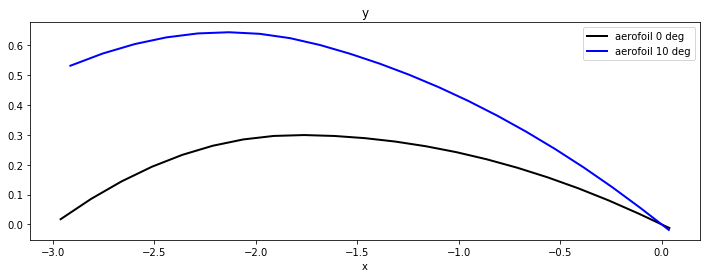

In [6]:
fig1 = plt.figure('Aerofoil',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(S01.Zeta[:,0],S01.Zeta[:,1],'k',lw=2,
                                label=r'aerofoil 0 deg')
ax1.plot(S02.Zeta[:,0],S02.Zeta[:,1],'b',lw=2,
                               label=r'aerofoil 10 deg')
ax1.set_xlabel(r'x')
ax1.set_title(r'y')
ax1.legend()
plt.show()

## Gust speed increment

### Cambered aerofoil

A cambered aerofoil is rotated of an angle $\alpha_0$ with respect to the horizontal line. The incoming flow speed is also rotated of an angle $\alpha_\infty$ so as to produce an effective angles of attack, $\alpha_e=\alpha_\infty-\alpha_0$. Vertical and horizontal forces are computed for a range of effective angles of attack. 

Two linearisations of this model are produced. While in both cases the aerofoil has a geometrical angle $\alpha_0$, two different profiles of the incoming flow are chosen so as to produce effective angles of 0 and 10 deg. An incremental gust profile is finally added to the linearised models to reproduce a range of effective angles of attack.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Testing steady aerofoil for M=20...
	Alpha effective=0.00 deg
	Alpha effective=0.10 deg
	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


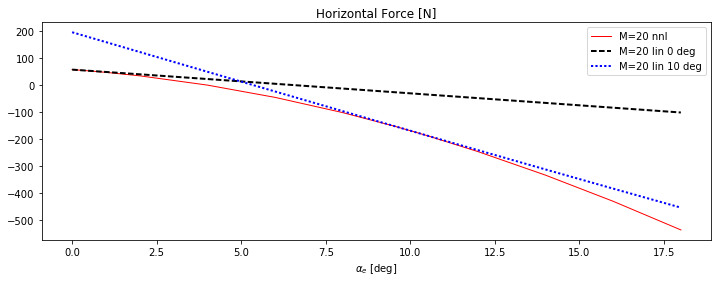

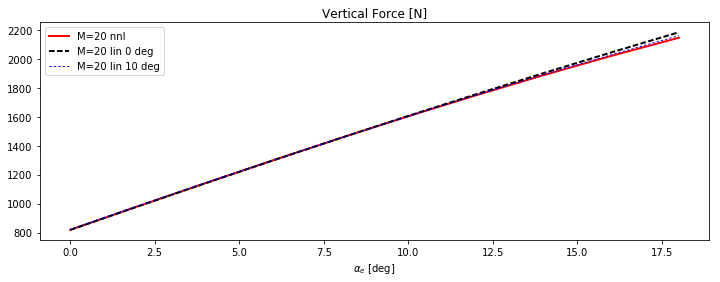

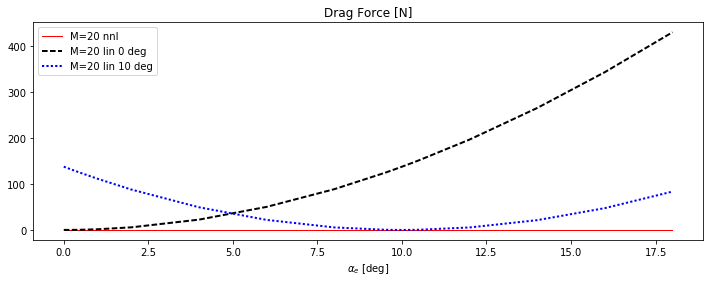

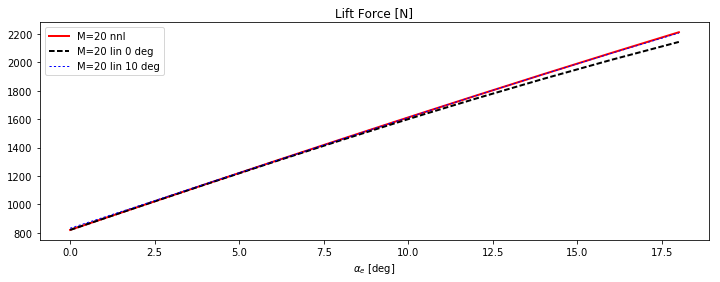

In [7]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,
            1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,
            12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CFXlin01,CFZlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXlin02,CFZlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXnnl,CFZnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

FZlin01,FXlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZlin02,FXlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZnnl,FXnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))	

# Reference input:
Mw=2
M=MList[mm]
chord=3.
b=0.5*chord
Uinf0=np.array([20.,0.])
rho=1.225
alpha0=4.0*np.pi/180. # angle of reference aerofoil w.r.t. horizontal line

# reference condition 1/2: aerofoil at 0 deg angle
S01=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho=1.225)
S01.build_camber_plate(Mcamb=10,Pcamb=4)
S02=copy.deepcopy(S01)

alpha_eff01=0.*np.pi/180.
alpha_inf=alpha_eff01-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S01.Wzeta[:,:]=Uinf_here-Uinf0
S01.solve_static_Gamma2d()
Fref01=np.sum(S01.Faero,0)

alpha_eff02=10.*np.pi/180.
alpha_inf=alpha_eff02-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S02.Wzeta[:,:]=Uinf_here-Uinf0
S02.solve_static_Gamma2d()
Fref02=np.sum(S02.Faero,0)

print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_eff=np.pi/180.*DAlphaList[aa]
    alpha_inf=alpha_eff-alpha0
    Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
    qinf_tot=0.5*rho*(S01.Uabs)**2
    print('\tAlpha effective=%.2f deg' %DAlphaList[aa])

    # Rotation matrix to project in wind axes
    ca,sa=np.cos(alpha_inf),np.sin(alpha_inf)
    R=np.array([ [ca,-sa], [sa,ca] ]).T  
    
    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho)
    Sref.build_camber_plate(Mcamb=10,Pcamb=4)
    Sref.Wzeta[:,:]=Uinf_here-Uinf0
    Sref.solve_static_Gamma2d()
    FXnnl[aa,mm],FZnnl[aa,mm]=np.sum(Sref.Faero,0)
    Dnnl[aa,mm],Lnnl[aa,mm]=np.dot(R,[FXnnl[aa,mm],FZnnl[aa,mm]])

    ### Linearised solution 01:
    Slin01=linuvlm.solver(S01)
    Slin01.Wzeta[:,:]=Uinf_here-(S01.Uzeta[0,:]+S01.Wzeta[0,:])
    Slin01.solve_static_Gamma2d()
    dFtot01=np.sum(Slin01.Faero,0)
    FXlin01[aa,mm],FZlin01[aa,mm]=dFtot01+Fref01
    Dlin01[aa,mm],Llin01[aa,mm]=np.dot(R,[FXlin01[aa,mm],FZlin01[aa,mm]])

    ### Linearised solution 02:
    Slin02=linuvlm.solver(S02)
    Slin02.Wzeta[:,:]=Uinf_here-(S02.Uzeta[0,:]+S02.Wzeta[0,:])
    Slin02.solve_static_Gamma2d()
    dFtot02=np.sum(Slin02.Faero,0)
    FXlin02[aa,mm],FZlin02[aa,mm]=dFtot02+Fref02
    Dlin02[aa,mm],Llin02[aa,mm]=np.dot(R,[FXlin02[aa,mm],FZlin02[aa,mm]])

clist=['k','r','b','0.6',]
### Aerodynamic forces
fig1 = plt.figure('FX',(12,4))
fig2 = plt.figure('FZ',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,FXnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,FXlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,FXlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,FZnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,FZlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,FZlin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Horizontal Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Vertical Force [N]')
ax2.legend()

### Aerodynamic forces in wind axes
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)
#
ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Drag Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Lift Force [N]')
ax2.legend()

plt.show()

As the incoming flow is not aligned with the horizontal line, and being the lift perpendicular to this, an horizontal component of the force is generated. For $\alpha_e=\alpha_\infty-\alpha_0<0$, this is positive, but as the incoming flow angle, $\alpha_\infty$ increases, this becomes negative ($\alpha_e>0$). It is worth noticing that the linearised solution grows linearly with the effective angle of attack.

As forces are projected in wind axes, the exact solution correctly predicts zero drag. The linearised solution also returns zero drag around the linearisation point. Both vertical and horizontal forces computed through the linearised model agree perfectly with the geometrically-exact solution as the perturbation speed goes to zero.

It is worth noting that the aerodynamic force predicted by the linear model is tangent to the exact one about the linearisation point. As a result, the linearisations will be able to predict changes in $F_x$. This behaviour, and its consequences, are more clear when looking at a flat plate. 

#### Note:
In test_linsta.py, the same test is repeated enforcing the aerofoil speed, $\zeta'$. The same results, with perfect match between linearised and exact solutions, are obtained.

### Flat plate at zero geometrical angle of attack

This case provides an understanding of the models used for the dynamic cases validation. The flow speed is horizontal (before perturbation) and the aerofoil has a zero geometrical angle of attack $\alpha_0$. A second reference conditions, with the incoming flow tilted so as to produce a non-zero effective angle of attack is also considered.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Testing steady aerofoil for M=20...
	Alpha effective=0.00 deg
	Alpha effective=0.10 deg
	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


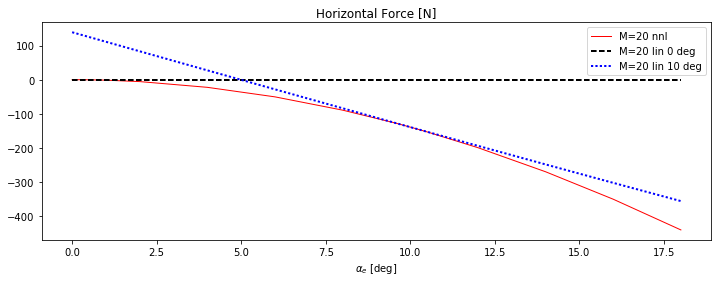

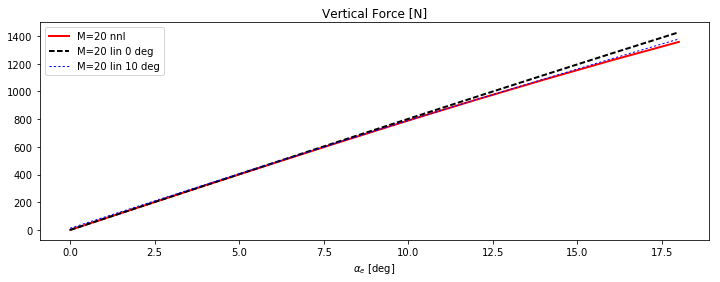

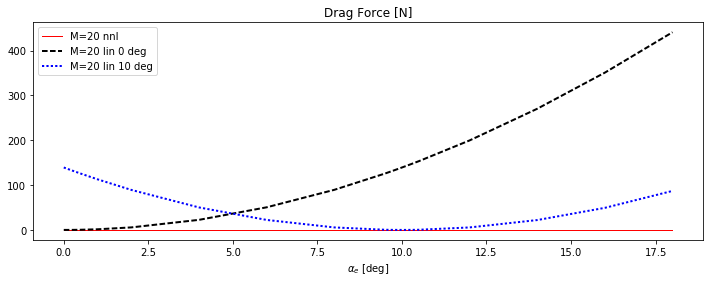

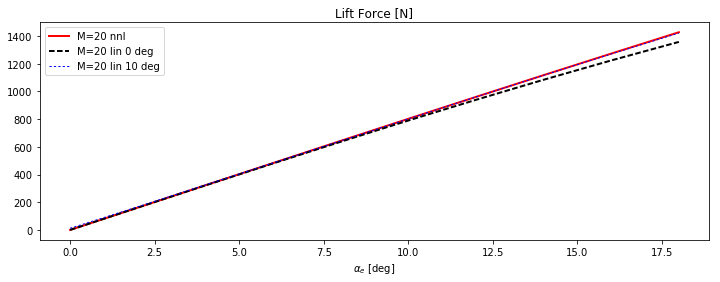

In [8]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,
            1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,
            12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CFXlin01,CFZlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXlin02,CFZlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXnnl,CFZnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

FZlin01,FXlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZlin02,FXlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZnnl,FXnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# Reference input:
Mw=2
M=MList[mm]
chord=3.
b=0.5*chord
Uinf0=np.array([20.,0.])
rho=1.225
alpha0=0.0*np.pi/180. # angle of reference aerofoil w.r.t. horizontal line

# reference condition 1/2: aerofoil at 0 deg angle
S01=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho=1.225)
S01.build_camber_plate(Mcamb=0,Pcamb=4)
S02=copy.deepcopy(S01)

alpha_eff01=0.*np.pi/180.
alpha_inf=alpha_eff01-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S01.Wzeta[:,:]=Uinf_here-Uinf0
S01.solve_static_Gamma2d()
Fref01=np.sum(S01.Faero,0)

alpha_eff02=10.*np.pi/180.
alpha_inf=alpha_eff02-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S02.Wzeta[:,:]=Uinf_here-Uinf0
S02.solve_static_Gamma2d()
Fref02=np.sum(S02.Faero,0)

print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_eff=np.pi/180.*DAlphaList[aa]
    alpha_inf=alpha_eff-alpha0
    Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
    qinf_tot=0.5*rho*(S01.Uabs)**2
    print('\tAlpha effective=%.2f deg' %DAlphaList[aa])

    # Rotation matrix to project in wind axes
    ca,sa=np.cos(alpha_inf),np.sin(alpha_inf)
    R=np.array([ [ca,-sa], [sa,ca] ]).T  
    
    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho)
    Sref.build_camber_plate(Mcamb=0,Pcamb=4)
    Sref.Wzeta[:,:]=Uinf_here-Uinf0
    Sref.solve_static_Gamma2d()
    FXnnl[aa,mm],FZnnl[aa,mm]=np.sum(Sref.Faero,0)
    Dnnl[aa,mm],Lnnl[aa,mm]=np.dot(R,[FXnnl[aa,mm],FZnnl[aa,mm]])

    ### Linearised solution 01:
    Slin01=linuvlm.solver(S01)
    Slin01.Wzeta[:,:]=Uinf_here-(S01.Uzeta[0,:]+S01.Wzeta[0,:])
    Slin01.solve_static_Gamma2d()
    dFtot01=np.sum(Slin01.Faero,0)
    FXlin01[aa,mm],FZlin01[aa,mm]=dFtot01+Fref01
    Dlin01[aa,mm],Llin01[aa,mm]=np.dot(R,[FXlin01[aa,mm],FZlin01[aa,mm]])

    ### Linearised solution 02:
    Slin02=linuvlm.solver(S02)
    Slin02.Wzeta[:,:]=Uinf_here-(S02.Uzeta[0,:]+S02.Wzeta[0,:])
    Slin02.solve_static_Gamma2d()
    dFtot02=np.sum(Slin02.Faero,0)
    FXlin02[aa,mm],FZlin02[aa,mm]=dFtot02+Fref02
    Dlin02[aa,mm],Llin02[aa,mm]=np.dot(R,[FXlin02[aa,mm],FZlin02[aa,mm]])

clist=['k','r','b','0.6',]
### Aerodynamic forces
fig1 = plt.figure('FX',(12,4))
fig2 = plt.figure('FZ',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,FXnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,FXlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,FXlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,FZnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,FZlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,FZlin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Horizontal Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Vertical Force [N]')
ax2.legend()

### Aerodynamic forces in wind axes
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)
#
ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Drag Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Lift Force [N]')
ax2.legend()

plt.show()

As for the cambered aerofoil, the aerodynamic force is tangent to the exact aerodynamic force around the linearisation point. For example, the model linearised about $\alpha_{eff}=0$ will not be able to predict $\Delta F_x$ as the initial flow is perturbed and tilts. Contrarely, the linearisation about $\alpha_{eff}=10$ deg will capture this effect. This gives an insight on how the circulatory component of the aerodynamic force will behave during plunge motion for plates at zero geometrical angle of attack: as the linearisation is about $\alpha_{eff}=0$, no horizontal force will be predicted. As it will be shown below, instead, if the plate has an angle of attack, the circulatory lift - together with the added mass, will contribute to the horizontal force.

Upon projection in wind axes, the linear models predict a nonzero drag as we move away from the linearisation point.

### Flat plate at non-zero geometrical angle of attack

This is the same case as above, but while the flow speed is horizontal (before perturbation) the aerofoil has a nonzero geometrical angle of attack $\alpha_0$. Two linearisations, at $\alpha_{eff}=0$ and $\alpha_{eff}=\alpha_0$ are considered.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Testing steady aerofoil for M=20...
	Alpha effective=0.00 deg
	Alpha effective=0.10 deg
	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


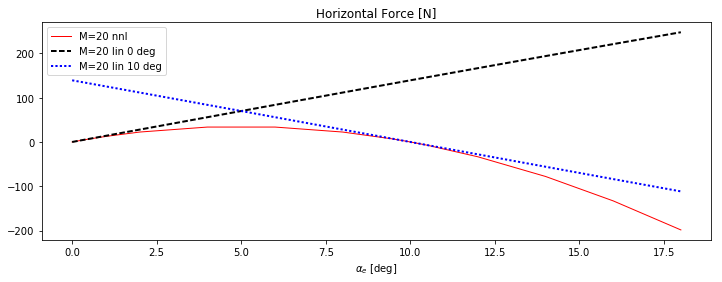

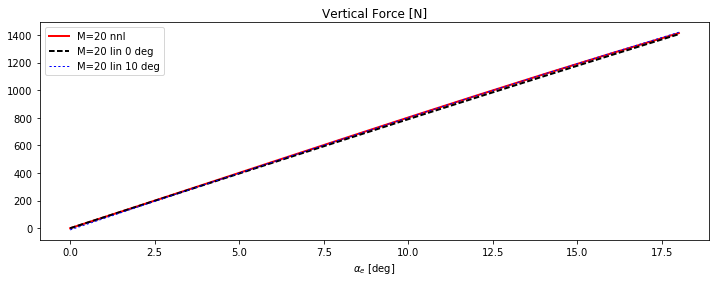

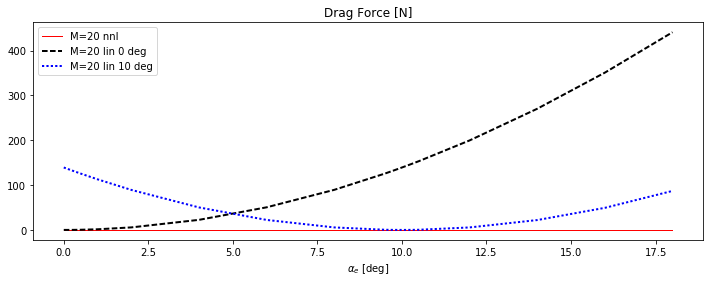

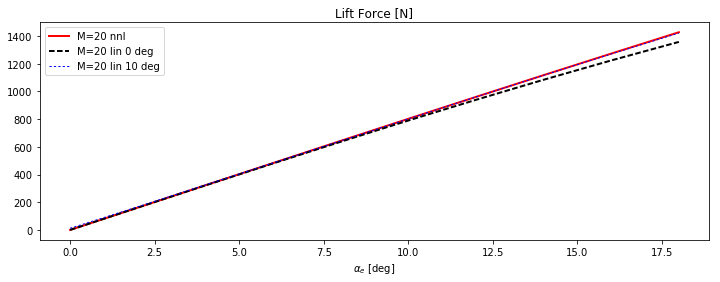

In [9]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,
            1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,
            12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CFXlin01,CFZlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXlin02,CFZlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CFXnnl,CFZnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

FZlin01,FXlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZlin02,FXlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
FZnnl,FXnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# Reference input:
Mw=2
M=MList[mm]
chord=3.
b=0.5*chord
Uinf0=np.array([20.,0.])
rho=1.225
alpha0=10.0*np.pi/180. # angle of reference aerofoil w.r.t. horizontal line

# reference condition 1/2: aerofoil at 0 deg angle
S01=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho=1.225)
S01.build_camber_plate(Mcamb=0,Pcamb=4)
S02=copy.deepcopy(S01)

alpha_eff01=0.*np.pi/180.
alpha_inf=alpha_eff01-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S01.Wzeta[:,:]=Uinf_here-Uinf0
S01.solve_static_Gamma2d()
Fref01=np.sum(S01.Faero,0)

alpha_eff02=10.*np.pi/180.
alpha_inf=alpha_eff02-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
S02.Wzeta[:,:]=Uinf_here-Uinf0
S02.solve_static_Gamma2d()
Fref02=np.sum(S02.Faero,0)

print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_eff=np.pi/180.*DAlphaList[aa]
    alpha_inf=alpha_eff-alpha0
    Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
    qinf_tot=0.5*rho*(S01.Uabs)**2
    print('\tAlpha effective=%.2f deg' %DAlphaList[aa])

    # Rotation matrix to project in wind axes
    ca,sa=np.cos(alpha_inf),np.sin(alpha_inf)
    R=np.array([ [ca,-sa], [sa,ca] ]).T  
    
    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf0,alpha0,rho)
    Sref.build_camber_plate(Mcamb=0,Pcamb=4)
    Sref.Wzeta[:,:]=Uinf_here-Uinf0
    Sref.solve_static_Gamma2d()
    FXnnl[aa,mm],FZnnl[aa,mm]=np.sum(Sref.Faero,0)
    Dnnl[aa,mm],Lnnl[aa,mm]=np.dot(R,[FXnnl[aa,mm],FZnnl[aa,mm]])

    ### Linearised solution 01:
    Slin01=linuvlm.solver(S01)
    Slin01.Wzeta[:,:]=Uinf_here-(S01.Uzeta[0,:]+S01.Wzeta[0,:])
    Slin01.solve_static_Gamma2d()
    dFtot01=np.sum(Slin01.Faero,0)
    FXlin01[aa,mm],FZlin01[aa,mm]=dFtot01+Fref01
    Dlin01[aa,mm],Llin01[aa,mm]=np.dot(R,[FXlin01[aa,mm],FZlin01[aa,mm]])

    ### Linearised solution 02:
    Slin02=linuvlm.solver(S02)
    Slin02.Wzeta[:,:]=Uinf_here-(S02.Uzeta[0,:]+S02.Wzeta[0,:])
    Slin02.solve_static_Gamma2d()
    dFtot02=np.sum(Slin02.Faero,0)
    FXlin02[aa,mm],FZlin02[aa,mm]=dFtot02+Fref02
    Dlin02[aa,mm],Llin02[aa,mm]=np.dot(R,[FXlin02[aa,mm],FZlin02[aa,mm]])

clist=['k','r','b','0.6',]
### Aerodynamic forces
fig1 = plt.figure('FX',(12,4))
fig2 = plt.figure('FZ',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,FXnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,FXlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,FXlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,FZnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,FZlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,FZlin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])

ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Horizontal Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Vertical Force [N]')
ax2.legend()

### Aerodynamic forces in wind axes
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)
#
ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
#
ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Drag Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Lift Force [N]')
ax2.legend()

plt.show()

In this case, the exact solution starts from $\alpha_{eff}=0$ with a slope, hence the linearisation will predict $\Delta F_x$ associated to the circulatory lift. The same occurs when the linearisation is about $\alpha_{eff}=\alpha_0$, i.e. when the flow is horizontal and the plate has an angle.

The $F_x$ trend of the exact solution is easily explained:
- when $\alpha_{eff}=0$, there is no aerodynamic force, hence $F_x=0$;
- as $\alpha_{eff}<\alpha_0$, there is an angle of attack, hence an upward directed aerodynamic force. However, the flow is pointing downward, hence the lift, perpendicular to the flow speed, is also producing drag ($F_x>0$).
- when $\alpha_eff=\alpha_0$, the flow is horizontal: the whole aerodynamic force is, therefore, vertical, hence $F_x=0$.
- when $\alpha_{eff}>\alpha_0$, the flow points upward, hence the aerodynamic force tilts creating a suction effect, which leads to $F_x<0$ (propulsion).